In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product

# 1.3 Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import math
from sklearn.preprocessing import MinMaxScaler


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

In [21]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [22]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [23]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [24]:
dftrain.columns

Index(['Unnamed: 0', 'file', 'DAS', 'plot nº', 'photo nº', 'species',
       'water_treatment', 'management', 'plot m2', 'avg_water (L m-2)',
       'N (kg microplot-1)', 'P (kg microplot-1)', 'K (kg microplot-1)',
       'avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg',
       'final yield (kg)', 'dataset'],
      dtype='object')

In [25]:
dftrain = dftrain.drop(columns = ['Unnamed: 0', 'species','water_treatment', 'management','file', 'DAS', 'plot nº', 'photo nº','avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg'])
df = df.drop(columns = ['Unnamed: 0', 'species', 'water_treatment', 'management','file', 'DAS', 'plot nº', 'photo nº','avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg'])

In [26]:
dftrain = dftrain[dftrain.dataset==False]
dfvalid = dftrain[dftrain.dataset==True]
dftest = df[df.dataset==True]

In [27]:
dftrain = dftrain.drop(columns ='dataset')
dfvalid = dfvalid.drop(columns ='dataset')
dftest = dftest.drop(columns ='dataset')

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# cat_attribs = ['water_treatment', 'management']
numerical_ix = ['plot m2', 'avg_water (L m-2)',
       'N (kg microplot-1)', 'P (kg microplot-1)', 'K (kg microplot-1)',
       'final yield (kg)']
full_pipeline = ColumnTransformer([('num', MinMaxScaler(), numerical_ix)], remainder='passthrough')
encoder = full_pipeline.fit(dftrain)
dftrain = encoder.transform(dftrain)
dftest = encoder.transform(dftest)

In [36]:
dftest[0]

array([0.        , 0.84713376, 0.        , 0.        , 0.        ,
       0.15990343])

In [30]:
x_train,y_train = dftrain[:,:-1],dftrain[:,-1]
x_test,y_test = dftest[:,:-1],dftest[:,-1]

In [31]:
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(random_state=2),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(random_state=2),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=30, random_state=2),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100, max_depth=30, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5,random_state=2),
    "GBR" :GradientBoostingRegressor(random_state=2),
    "AdaB" :AdaBoostRegressor(random_state=2),
    "XGBOOST" : XGBRegressor(random_state=2),
    
}
for name, estimator in ESTIMATORS.items():     
    estimator.fit(x_train, y_train)  
    print("%s\t%f\t%f\t%f" % (name,mean_absolute_error(y_test*(10.55-0.8579)+0.8579, estimator.predict(x_test)*(10.55-0.8579)+0.8579),
          mean_squared_error(y_test*(10.55-0.8579)+0.8579, estimator.predict(x_test)*(10.55-0.8579)+0.8579),
        math.sqrt(mean_squared_error(y_test*(10.55-0.8579)+0.8579, estimator.predict(x_test)*(10.55-0.8579)+0.8579))))

Extra trees	0.709733	0.744944	0.863101
K-nn	0.583900	0.447308	0.668811
Linear regression	0.729952	0.785369	0.886210
Ridge	0.719253	0.778242	0.882180
Lasso	3.785050	16.141466	4.017644
ElasticNet	3.785050	16.141466	4.017644
RandomForestRegressor	0.705455	0.731688	0.855388
ExtraTreesRegressor	0.709733	0.744944	0.863101
Decision Tree Regressor	0.709733	0.744944	0.863101
GBR	0.709741	0.745017	0.863144
AdaB	0.696770	0.704270	0.839208
XGBOOST	0.710073	0.745877	0.863641


In [32]:
model = XGBRegressor(random_state=2)
model.fit(x_train, y_train)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

In [33]:
from matplotlib import pyplot


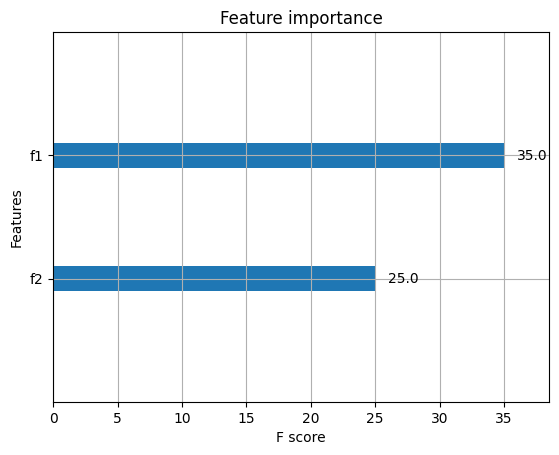

In [34]:
from xgboost import plot_importance
plot_importance(model)
pyplot.show()


In [31]:
np.unique(df['management'])

array(['conv', 'eco'], dtype=object)

In [33]:
len(x_train[0])

16

In [42]:
model.predict(dftest[0:2,:-1])

array([0.14198473, 0.14198473], dtype=float32)

In [43]:
dftest[0]

array([0.        , 0.84713376, 0.        , 0.        , 0.        ,
       0.15990343])